In [285]:
# Francisco Dominguez Mateos
# 03/08/2020
# SIREN for SDF in 2D
# added loss_sdf that is SIREN loss for sdf
# from:https://www.youtube.com/watch?v=Q5g3p9Zwjrk
#      https://vsitzmann.github.io/siren/

In [286]:
import time
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, Dense, Relu, LogSoftmax
from jax.experimental import optimizers

import matplotlib.pyplot as plt
import cv2
print("OpenCV v",cv2.__version__)

OpenCV v 4.2.0


In [287]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(1)

In [288]:
def Siren(s=[1000]*5,omega_0=30.0):
    def init_fun(key,input_shape):
        """ Initialize the weights of all layers of a linear layer network """
        sizes=[input_shape[-1]]+s
        print(sizes)
        keys = random.split(key, len(sizes))
        print(len(keys))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, rng):
            scale=np.sqrt(6.0/float(m))/omega_0
            w_key, b_key = random.split(rng)
            return scale * random.uniform(w_key, (n, m),minval=-1.0, maxval=1.0),scale * random.uniform(b_key, (n,  ),minval=-1.0, maxval=1.0)
        # actually they are pairs plus the random key
        pairs=list(zip(sizes[:-1], sizes[1:], keys))
        params=[initialize_layer(m, n, k) for m, n, k in pairs[:]]
        # The scale of first layes is different
        m,n,k=pairs[0]
        w_key, b_key = random.split(k)
        scale=1.0/float(m)
        print("scale",m,n,scale)
        params[0]=scale*random.uniform(w_key, (n, m),minval=-1.0, maxval=1.0),scale * random.uniform(b_key, (n,  ),minval=-1.0, maxval=1.0)
        output_shape =  input_shape[:-1] + (sizes[-1],)
        return (output_shape,params)
    def apply_fun(params, inputs, **kwargs):
        """ Compute the forward pass for each example individually """
        activations = inputs
        # Loop over the Siren hidden layers
        for w, b in params[:-1]:
            linear = np.dot(w,activations)+b
            activations=np.sin(omega_0*linear)
        w,b=params[-1]
        linear= np.dot(w,activations)+b
        #return activations#.reshape(())
        return linear#.reshape(())
    return init_fun, apply_fun

In [289]:
def net_pre_grad(params,x):
    a=net(params,x)
    return a.reshape(())

In [290]:
init,net=Siren([500]*5+[1])
net_grad=grad(net_pre_grad,argnums=1)

input_shape=(-1,2)
output_shape,params=init(rng,input_shape)
print(output_shape)
for l in params:
    print(l[0].shape,l[1].shape)

[2, 500, 500, 500, 500, 500, 1]
7
scale 2 500 0.5
(-1, 1)
(500, 2) (500,)
(500, 500) (500,)
(500, 500) (500,)
(500, 500) (500,)
(500, 500) (500,)
(1, 500) (1,)


In [291]:
net(params,np.array([0.5,0.5]))

DeviceArray([-0.03567601], dtype=float32)

In [292]:
net_grad(params,np.array([0.5,0.5]))

DeviceArray([0.38260168, 0.37473568], dtype=float32)

In [293]:
# Make a batched version of the `net` function
batch_net      = vmap(net     , in_axes=(None, 0), out_axes=0)
batch_net_grad = vmap(net_grad, in_axes=(None, 0), out_axes=0)

In [294]:
def getInputOrdered(size):
    width=size[1]
    height=size[0]
    X, Y = np.meshgrid(range(height),range(width))
    X=X/height*2.0-1.0
    Y=Y/width *2.0-1.0
    xy=np.dstack((Y,X))
    input_ordered=np.reshape(xy,(-1,2))
    return input_ordered

def build_sdf(size):
    width=size[1]
    height=size[0]
    input_ordered=getInputOrdered(size)
    print(input_ordered.shape)

    img=batch_net(params,input_ordered)
    print(img.shape)
    return np.reshape(img,(height,width))

def build_sdf_grad(size):
    width=size[1]
    height=size[0]
    input_ordered=getInputOrdered(size)
    print(input_ordered.shape)

    img=batch_net_grad(params,input_ordered)
    print(img.shape)
    return np.reshape(img,(height,width,2))

(2500, 2)
(2500, 1)
0.08763525 -0.09712066


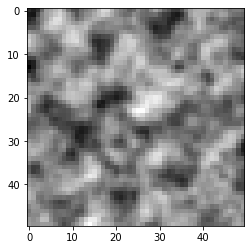

In [295]:
W=50
H=50
input_ordered=getInputOrdered((H,W))
img=build_sdf((H,W))
print(np.max(img),np.min(img))
plt.imshow((img+1.0)/2.0,cmap='gray',)

In [296]:
input_ordered=getInputOrdered((H,W))
img=build_sdf_grad((H,W))
print(np.max(img),np.min(img))

(2500, 2)
(2500, 2)
1.4068317 -1.3989788


1.4068317 -1.3989788
0.5013994 -0.49860063
(2500, 3)


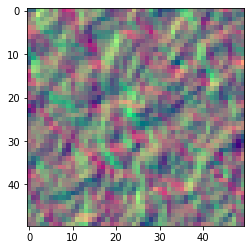

In [297]:
gsdf_values=img.reshape((-1,2))
print(np.max(gsdf_values),np.min(gsdf_values))
gmax=np.max(gsdf_values)
gmin=np.min(gsdf_values)
s=gmax-gmin
gsdf_values_norm=gsdf_values/s
print(np.max(gsdf_values_norm),np.min(gsdf_values_norm))
z=np.zeros((gsdf_values_norm.shape[0],1))
v=np.hstack((gsdf_values_norm,z))
print(v.shape)
img=np.reshape(v,(H,W,3))
plt.imshow((img-np.min(gsdf_values_norm)))

In [298]:
@jit
def sdf_2d(point):
    x,y=point
    d0=x*x+y*y-0.30*0.30
    x1=x+0.3
    y1=y-0.3
    d1=x1*x1+y1*y1-0.15*0.15
    x2=x+0.3
    y2=y+0.3
    d2=x2*x2+y2*y2-0.15*0.15
    return np.min(np.array([d0,d1,d2]))
gsdf_2d=grad(sdf_2d)

print( sdf_2d((0.2,0.2)))
print(gsdf_2d((0.2,0.2)))
batch_sdf_2d =vmap( sdf_2d, in_axes=(None, 0), out_axes=0)
batch_gsdf_2d=vmap(gsdf_2d, in_axes=(None, 0), out_axes=0)

-0.009999998
(DeviceArray(0.4, dtype=float32), DeviceArray(0.4, dtype=float32))


In [299]:
#sdf_value=batch_sdf_2d(input_ordered)

In [300]:
mapped=list(map(sdf_2d,input_ordered))
sdf_values=np.reshape(np.array(mapped),(-1,1))
print(np.max(sdf_values),np.min(sdf_values))
print(sdf_values.shape)
s=np.max(sdf_values)-np.min(sdf_values)
sdf_values/=s
print(np.max(sdf_values),np.min(sdf_values))

1.8315998 -0.09
(2500, 1)
0.953164 -0.046835974


In [301]:
gmapped=list(map(gsdf_2d,input_ordered))    
gsdf_values=np.reshape(np.array(gmapped),(-1,2))
print("gsdf_values",gsdf_values.shape,np.max(gsdf_values),np.min(gsdf_values))

gsdf_values (2500, 2) 1.9199998 -2.0


gsdf_values_norm (2500, 3) 0.48979586 -0.5102041


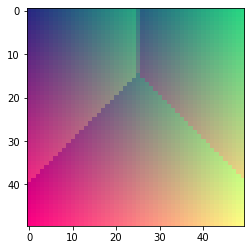

In [302]:
gmax=np.max(gsdf_values)
gmin=np.min(gsdf_values)
s=gmax-gmin
gsdf_values_norm=gsdf_values/s
z=np.zeros((gsdf_values_norm.shape[0],1))
v=np.hstack((gsdf_values_norm,z))
img=np.reshape(v,(H,W,3))
plt.imshow((img-np.min(gsdf_values_norm)))
print("gsdf_values_norm",v.shape,np.max(gsdf_values_norm),np.min(gsdf_values_norm))

<ipython-input-303-191ddf04333d>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cs.cmap.set_over('red')
<ipython-input-303-191ddf04333d>:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cs.cmap.set_under('blue')


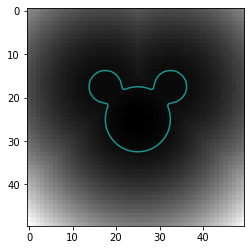

In [303]:
img=np.reshape(sdf_values,(H,W))
plt.imshow((img+1.0)/2.0,cmap="gray")
cs=plt.contour(range(H),range(W),img,0)
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()

In [304]:
@jit
def mse_loss(params, inputs, targets):
    """ Calculate the Mean Squared Error Prediction Loss. """
    preds      = batch_net     (params, inputs)
    return np.mean((preds - targets)**2)

$$L_\Omega=\sum_\Omega abs( ||\nabla_x\phi(x)||-1)$$
$$L_{\Omega_0}=\sum_{\Omega_0}|\phi(x)|+|1-\nabla_x\phi(x)·n(x)|$$
$$\psi(\phi(x))=e^{-\alpha |\phi(x)|}\;\;\;\alpha>>0$$
$$L_{\Omega-\Omega_0}=\sum_{\Omega-\Omega_0}\psi(\phi(x))$$
$$L_{sdf}=L_\Omega+L_{\Omega_0}+L_{\Omega-\Omega_0}$$

In [305]:
#@jit
def loss_sdf(params,inputs,targetsidx):
    #hyper params valuesfrom paper
    #constraint gradient=1
    λ1=5e1
    # off-surface penalization and sdf constraint
    λ2=3e3
    # oriented surface normal constraint
    λ3=1e2
    
    targets,idxs=targetsidx
    #print("targets",targets.shape)
    #print("idxs",idxs.shape)
    values,normals,idx_in_surface=targets[:,0],targets[:,1:3],targets[:,3]
    idx_in_surface=idxs
    idx_out_surface=np.logical_not(idx_in_surface)
    #values_in_surface =values[idx_in_surface]
    #values_out_surface=values[idx_out_surface]
    normals_in_surface=normals[idx_in_surface]
    
    # Value predictions for SDF is just distance to the surface
    preds      = batch_net     (params, inputs)
    preds_in_surface =preds[idx_in_surface]
    preds_out_surface=preds[idx_out_surface]
    # gradient of predictions given inputs
    # actally these are normals of the isosurfaces of the scalar field
    preds_grad = batch_net_grad(params,inputs)
    #print("preds_grad",preds_grad.shape)
    preds_grad_in_surface=preds_grad[idx_in_surface]
    #print("preds_grad_in_surface",preds_grad_in_surface.shape)
    
    preds_norm     =np.linalg.norm(preds     ,axis=1).reshape(-1,1)#this could be abs since they are scalars
    #print("preds_norm",preds_norm.shape)
    preds_norm_out_surface=preds_norm[idx_out_surface]
    #print("preds_norm_out_surface",preds_norm_out_surface.shape)
    preds_norm_in_surface =preds_norm[idx_in_surface]
    #print("preds_norm_in_surface",preds_norm_in_surface.shape)
    preds_grad_norm=np.linalg.norm(preds_grad,axis=1)
    #print("preds_grad_norm",preds_grad_norm.shape)
    #Learned grad must have length one
    #it doesn't have to it could learn the actual normal
    #on doing this we don't have to know the actual normal
    loss_norm=np.abs(preds_grad_norm-1)
    #print("loss_norm=",loss_norm.shape)
    
    # This is the loss for the zero level set (idx_in_surface)
    # This has two parts:
    # 1.-predictions of in surface have to be 0
    # 2.-given the normal the predicted gradient has to be equal and with this we force the gradient to have norm 1
    #    if we had use traditional euclidena distance we wouldn't have constrain to have norm 1 so strongly
    gradDotNormal=np.dot(preds_grad_in_surface,np.transpose(normals_in_surface))
    #print("gradDotNormal=",gradDotNormal.shape)
    loss_in_surface=preds_norm_in_surface
    loss_nornal    =np.abs(-gradDotNormal+1)
    #print("loss_in_surface=",loss_in_surface.shape)
    # Values out of the surface are to be as far as posible from 0 this is the reason of the phi function
    # penalize values near of 0. Without phi a naive solution would be all 0
    α=100
    ψ=np.exp(-α*preds_norm_out_surface)
    loss_out_surface =ψ
    #print("loss_out_surface=",loss_out_surface.shape)
    # total loss is the addition of all above losses
    loss=λ1*np.mean(loss_norm)+λ2*np.mean(loss_in_surface)+λ3*np.mean(loss_nornal)+λ2*np.mean(loss_out_surface)
    return loss

In [306]:
idxs=np.abs(sdf_values)<0.01
targets=np.hstack((sdf_values,gsdf_values))
print(targets.shape)

(2500, 3)


$$L_\Omega=\sum_\Omega|\phi(x)-d(x)|+||\nabla\phi(x)-n(x)||_2$$

In [307]:
@jit
def loss_sdf_easy(params,inputs,targets):
    values,normals=targets[:,0],targets[:,1:3]
    
    phi      = batch_net     (params, inputs)
    phi_grad = batch_net_grad(params,inputs)
    phi=np.reshape(phi,(-1,))
    print("phi",phi.shape)
    print("values",values.shape)
    loss_d=(phi - values)**2
    loss_n=np.linalg.norm(phi_grad-normals,axis=1)
    print("loss_d",loss_d.shape)
    print("loss_n",loss_n.shape)
    loss=loss_d+loss_n
    return np.mean(loss)

In [308]:
@jit
def accuracy(params,inputs,targets):
    return loss_sdf_easy(params,inputs,targets)
@jit
def update(params, x, y, opt_state):
    #print("y=",len(y))
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss_sdf_easy)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [309]:
targets=np.hstack((sdf_values,gsdf_values))
print(targets.shape)

(2500, 3)


In [310]:
print(input_ordered.shape)
print(sdf_values.shape)
loss_sdf_easy(params,input_ordered,targets)

(2500, 2)
(2500, 1)
phi (2500,)
values (2500,)
loss_d (2500,)
loss_n (2500,)


DeviceArray(1.3743389, dtype=float32)

In [311]:
print(input_ordered.shape)
print(sdf_values.shape)
mse_loss(params,input_ordered,sdf_values)

(2500, 2)
(2500, 1)


DeviceArray(0.07596491, dtype=float32)

In [312]:
# Defining an optimizer in Jax
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [315]:
num_epochs = 1001
num_classes = 10

In [316]:
def run_training_loop(num_epochs, opt_state):
    global params
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params,input_ordered,targets)
    test_acc  = accuracy(params,input_ordered,targets)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss = update(params, input_ordered,targets, opt_state)
        train_loss.append(loss)

        train_acc = accuracy(params,input_ordered,targets)
        test_acc  = accuracy(params,input_ordered,targets)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        if(epoch %500 ==0):
            epoch_time = time.time() - start_time
            print("Epoch {} | T: {:0.3f} | Train A: {:0.6f} | Test A: {:0.6f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))
    return opt_state, train_loss, log_acc_train, log_acc_test

In [317]:
opt_state, train_loss, train_log, test_log =run_training_loop(num_epochs,opt_state)

phi (2500,)
values (2500,)
loss_d (2500,)
loss_n (2500,)
phi (2500,)
values (2500,)
loss_d (2500,)
loss_n (2500,)
Epoch 1 | T: 0.719 | Train A: 1.535275 | Test A: 1.535275
Epoch 501 | T: 0.017 | Train A: 0.041801 | Test A: 0.041801
Epoch 1001 | T: 0.017 | Train A: 0.032581 | Test A: 0.032581


In [318]:
print(input_ordered.shape)
print(sdf_values.shape)
mse_loss(params,input_ordered,sdf_values)

(2500, 2)
(2500, 1)


DeviceArray(0.00793013, dtype=float32)

(2500, 2)
(2500, 1)
0.7766678 -0.19970293


<ipython-input-319-995e13db539a>:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cs.cmap.set_over('red')
<ipython-input-319-995e13db539a>:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cs.cmap.set_under('blue')


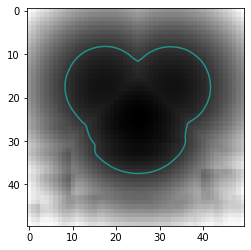

In [319]:
img=build_sdf((H,W))
print(np.max(img),np.min(img))
plt.imshow((img+1.0)/2.0,cmap="gray")
cs=plt.contour(range(H),range(W),img,0)
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()

In [320]:
input_ordered=getInputOrdered((H,W))
img=build_sdf_grad((H,W))
print(np.max(img),np.min(img))

(2500, 2)
(2500, 2)
1.9578922 -2.0114818


0.49324962 -0.5067504
(2500, 3)


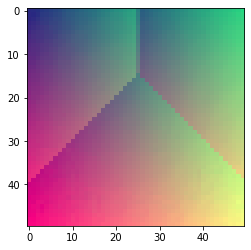

In [321]:
gsdf_values=img.reshape((-1,2))
gmax=np.max(gsdf_values)
gmin=np.min(gsdf_values)
s=gmax-gmin
gsdf_values/=s
print(np.max(gsdf_values),np.min(gsdf_values))
z=np.zeros((gsdf_values.shape[0],1))
v=np.hstack((gsdf_values,z))
print(v.shape)
img=np.reshape(v,(H,W,3))
plt.imshow((img-np.min(gsdf_values)))

In [322]:
net(params,np.array([0,0]))

DeviceArray([-0.19970295], dtype=float32)

In [323]:
net_grad(params,np.array([0.0,0.0]))

DeviceArray([-0.00373568, -0.02697736], dtype=float32)

In [324]:
(net(params,np.array([0.000005,0.0]))-net(params,np.array([0.,0.0])))/0.000005

DeviceArray([-0.00596046], dtype=float32)

In [325]:
(net(params,np.array([0.0,0.00001]))-net(params,np.array([0.0,0.0])))/0.00001

DeviceArray([-0.02682209], dtype=float32)